In [1]:
import numpy as np
import matplotlib.pyplot as plt
from discretize import TensorMesh
from SimPEG import (
    maps, data_misfit, regularization, optimization, inverse_problem,
    inversion, data, directives
)
from SimPEG import seismic

/var/folders/r2/7lcfqppd1sg_grmh2b54b79r0000gn/T/ipykernel_73802/3057968551.py:4: FutureWarning: Importing `SimPEG` is deprecated. please import from `simpeg`.
  from SimPEG import (


In [2]:
extent_x = 200
extent_y = 400  

dx = 10  
dy = 10  

nx = int(np.ceil(extent_x / dx))
ny = int(np.ceil(extent_y / dy))

hx = np.ones(nx) * dx
hy = np.ones(ny) * dy

In [3]:
mesh = TensorMesh([hx, hy])
mesh

TensorMesh: 800 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     20          0.00        200.00     10.00     10.00    1.00
   y     40          0.00        400.00     10.00     10.00    1.00

In [4]:
n_src = 10
y_src = np.linspace(dy/2, extent_y - dy/2, n_src)

source_locations = np.c_[np.zeros_like(y_src), y_src]
receiver_locations = np.c_[np.zeros_like(y_src) + mesh.nodes_x[-1], y_src]

In [5]:
source_locations

array([[  0.        ,   5.        ],
       [  0.        ,  48.33333333],
       [  0.        ,  91.66666667],
       [  0.        , 135.        ],
       [  0.        , 178.33333333],
       [  0.        , 221.66666667],
       [  0.        , 265.        ],
       [  0.        , 308.33333333],
       [  0.        , 351.66666667],
       [  0.        , 395.        ]])

In [6]:
receiver_locations

array([[200.        ,   5.        ],
       [200.        ,  48.33333333],
       [200.        ,  91.66666667],
       [200.        , 135.        ],
       [200.        , 178.33333333],
       [200.        , 221.66666667],
       [200.        , 265.        ],
       [200.        , 308.33333333],
       [200.        , 351.66666667],
       [200.        , 395.        ]])

In [7]:
layer_velocities = [1500, 2000, 2500, 3000]  
layer_boundaries = [100, 200, 300]  

velocity_model = np.zeros(mesh.n_cells)

for i in range(mesh.n_cells):
    y_center = mesh.cell_centers[i, 1]
    if y_center < layer_boundaries[0]:
        velocity_model[i] = layer_velocities[0]
    elif y_center < layer_boundaries[1]:
        velocity_model[i] = layer_velocities[1]
    elif y_center < layer_boundaries[2]:
        velocity_model[i] = layer_velocities[2]
    else:
        velocity_model[i] = layer_velocities[3]

true_slowness_model = 1 / velocity_model
background_velocity = 2000 
background_slowness_model = 1 / (background_velocity * np.ones(mesh.n_cells))

In [8]:
def plot_model_survey(
    mesh, model, source_locations, receiver_locations, ax=None, 
    show_raypaths=True, vmin=None, vmax=None
):
    if ax is None: 
        fig, ax = plt.subplots(1, 1)

    cb = plt.colorbar(
    mesh.plot_image(model, ax=ax, pcolor_opts={"vmin": vmin, "vmax": vmax})[0], 
    ax=ax,
    ticks=[1500, 2000, 2500, 3000]
)
    cb.set_label("velocity (m/s)")
    
    ax.set_aspect(1)

    ax.plot(source_locations[:, 0], source_locations[:, 1], "ws", ms=6)
    ax.plot(receiver_locations[:, 0], receiver_locations[:, 1], "wv", ms=6)
    
    if show_raypaths is True: 
        for i in range(source_locations.shape[0]):
            for j in range(receiver_locations.shape[0]):
                ax.plot(
                    np.r_[source_locations[i, 0], receiver_locations[j, 0]],
                    np.r_[source_locations[i, 1], receiver_locations[j, 1]],
                    color="w",
                    linewidth=0.5
                )
    return ax

<Axes: xlabel='x', ylabel='y'>

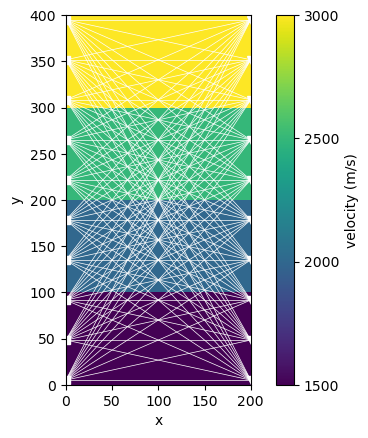

In [9]:
plot_model_survey(
    mesh, velocity_model, source_locations, receiver_locations,
    show_raypaths=True
)

In [10]:
rx = seismic.straight_ray_tomography.Rx(receiver_locations)
source_list = []
for i in range(y_src.size):
    source_list.append(
        seismic.straight_ray_tomography.Src(
            location=source_locations[i, :], receiver_list=[rx]
        )
    )

tomo_survey = seismic.straight_ray_tomography.Survey(source_list)

simulation = seismic.straight_ray_tomography.Simulation(
    mesh=mesh,
    survey=tomo_survey,
    slownessMap=maps.IdentityMap(mesh)
)

In [11]:
background_data = simulation.dpred(background_slowness_model)
clean_data = simulation.dpred(true_slowness_model)

relative_error = 0.02
np.random.seed(1)
noisy_data = clean_data + np.random.randn(len(clean_data)) * relative_error * np.abs(clean_data)
background_noisy_data = (
    background_data + 
    np.random.randn(len(clean_data)) * relative_error * np.abs(background_data)
)

In [12]:
levels = np.linspace(0.05, 0.25, 21)
contours = [0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

Text(0.5, 1.0, '(b) observed data')

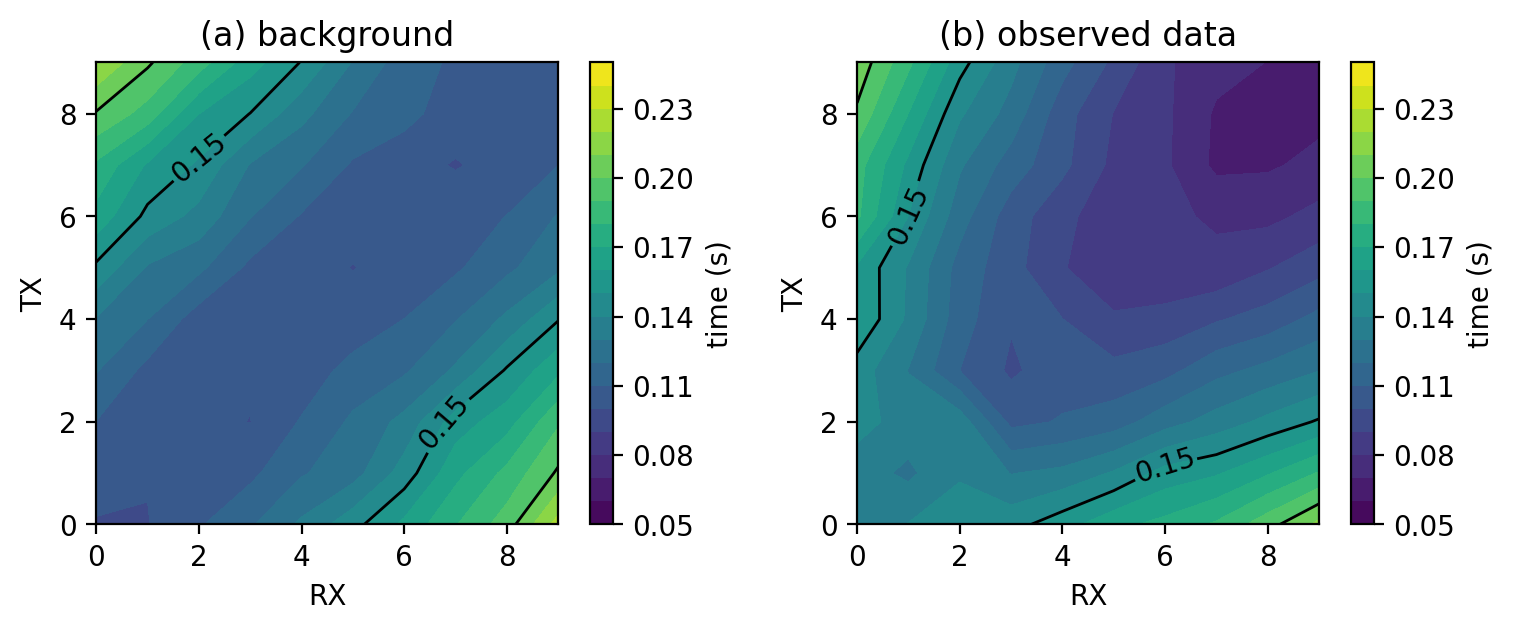

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3), dpi=200)

for i, dplot in enumerate([background_noisy_data, noisy_data]): 
    cb = plt.colorbar(ax[i].contourf(dplot.reshape(n_src, n_src, order="F"), levels=levels))
    
    CS = ax[i].contour(
            dplot.reshape(n_src, n_src, order="F"), 
            levels=contours, colors=["k"]*len(contours), linewidths=[1]*len(contours)
    )
    ax[i].clabel(CS, inline=True, fontsize=10)
    ax[i].set_aspect(1)

    ax[i].set_xlabel("RX")
    ax[i].set_ylabel("TX")
    cb.set_label("time (s)")

ax[0].set_title("(a) background")
ax[1].set_title("(b) observed data")

In [14]:
data_object = data.Data(tomo_survey, dobs=noisy_data, relative_error=relative_error)

dmis = data_misfit.L2DataMisfit(data_object, simulation)

alpha_s = 1e-6
alpha_x = 1
alpha_y = 1

reg_s = regularization.Smallness(mesh, reference_model=background_slowness_model)
reg_x = regularization.SmoothnessFirstOrder(mesh, orientation="x")
reg_y = regularization.SmoothnessFirstOrder(mesh, orientation="y")
reg = alpha_s * reg_s + alpha_x * reg_x + alpha_y * reg_y

opt = optimization.ProjectedGNCG(lower=0.0, maxIter=30)

invprob = inverse_problem.BaseInvProblem(dmis, reg, opt)

chifact = 0.1
beta0_ratio = 1e2
coolingFactor = 1.5

save = directives.SaveOutputDictEveryIteration()
beta_estimate = directives.BetaEstimate_ByEig(beta0_ratio=beta0_ratio)
beta_schedule = directives.BetaSchedule(coolingFactor=coolingFactor, coolingRate=1)

directives_list = [beta_estimate, beta_schedule, save]

inv = inversion.BaseInversion(invprob, directives_list)

In [15]:
m0 = background_slowness_model
mopt = inv.run(m0)


Running inversion with SimPEG v0.23.0
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Mumps and no solver_opts.***
                    
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.42e+10  1.40e+04  3.11e-37  1.40e+04    2.05e+06      0              
   1  2.28e+10  7.08e+02  4.03e-08  1.63e+03    3.51e+05      0              
   2  1.52e+10  5.03e+02  4.75e-08  1.23e+03    2.79e+05      0   Skip BFGS  
   3  1.01e+10  3.73e+02  5.44e-08  9.25e+02    2.26e+05      0   Skip BFGS  
   4  6.76e+09  2.90e+02  6.11e-08  7.03e+02    1.8

In [16]:
def plot_tikhonov_curves(beta_values, phi_d, phi_m, phid_star=None, iteration=None, ax=None): 
    if ax is None: 
        fig, ax = plt.subplots(1, 3, figsize=(12,3))
    
    ax[0].plot(beta_values, phi_d)
    ax[1].plot(beta_values, phi_m)
    ax[2].plot(phi_m, phi_d)

    if phid_star is not None: 
        ax[0].plot(beta_values, np.ones_like(beta_values) * phid_star, "--k")
        ax[2].plot(phi_m, np.ones_like(beta_values) * phid_star, "--k")

    ax[0].set_ylabel("$\\phi_d$")
    ax[1].set_ylabel("$\\phi_m$")
    ax[2].set_ylabel("$\\phi_d$")
    ax[2].set_xlabel("$\\phi_m$")
    
    if iteration is not None: 
        ax[0].plot(beta_values[iteration], phi_d[iteration], "C3o")
        ax[1].plot(beta_values[iteration], phi_m[iteration], "C3o")
        ax[2].plot(phi_m[iteration], phi_d[iteration], "C3o")

    for a in ax[:2]:
        a.invert_xaxis()
        a.set_xlabel("$\\beta$")
    plt.tight_layout()
    
    return ax

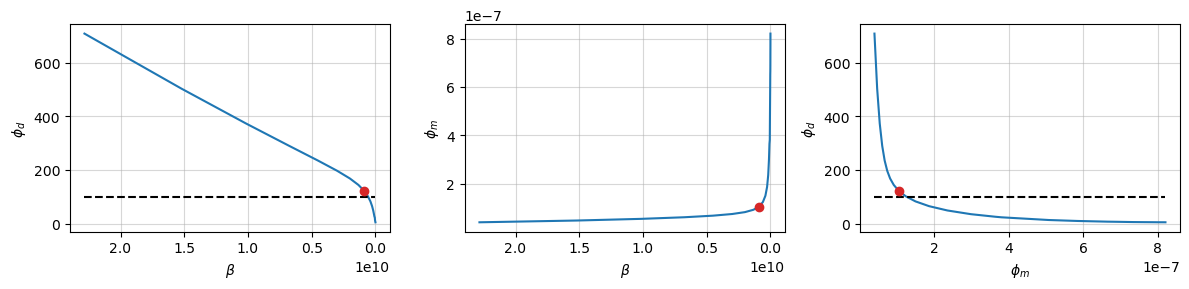

In [17]:
betas = [save.outDict[i]["beta"] for i in save.outDict.keys()]
phi_d = [save.outDict[i]["phi_d"] for i in save.outDict.keys()]
phi_m = [save.outDict[i]["phi_m"] for i in save.outDict.keys()]
models = [save.outDict[i]["m"] for i in save.outDict.keys()]

iteration = 8
ax = plot_tikhonov_curves(betas, phi_d, phi_m, phid_star=len(noisy_data), iteration=iteration)
for a in ax.flatten():
    a.grid("both", alpha=0.5)

<Axes: xlabel='x', ylabel='y'>

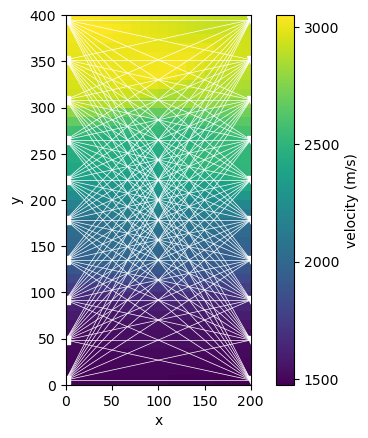

In [18]:
iteration = 8
plot_model_survey(
    mesh, 1./models[iteration], source_locations, receiver_locations,
    show_raypaths=True,
)